# Workflow

In [14]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   #Need seaborn for heatmap


# Importing training and test data csv files to pandas dataframes
column_names=['spacegroup','N_total','x_Al','x_Ga','x_In','a','b','c','alpha', 'beta','gamma', 'del_Hf', 'bandgap']
df_train = pd.read_csv('./train.csv', header=0, index_col = 0, names = column_names)
df_test = pd.read_csv('./test.csv', header=0, index_col = 0, names = column_names[0:11])

## Step 0: Working Data

Raw data was manipulated to  csv files in the folders 'train_xyz2csv' and 'test_xyz2csv' respectively. Each csv file is named as the id of the structure and contains only the fractional coordinates of atoms. Note that atomic coordinates are converted from cartesian to fractional to have a normalized data to work with.

### How does this data look like?
index: id = id of the crystal structure that ranges from 1 to 2400 for training dataset and 1 to 600 for test dataset

0: spacegroup = spacegroup of the crystal structure

1: N_total = number of total atoms in the unit cell

2: x_Al = percent_atom_al

3: x_Ga = percent_atom_ga

4: x_In = percent_atom_in

5: a = lattice_vector_1_ang

6: b = lattice_vector_2_ang

7: c = lattice_vector_3_ang

8: alpha = lattice_angle_alpha_degree

9: beta = lattice_angle_beta_degree

10: gamma = lattice_angle_gamma_degree

11: del_Hf = formation_energy_ev_natom (available only for training data)

12: bandgap = bandgap_energy_ev (available only for training data)

In [15]:
#Function that converts csv files to fractional coordinates
def fractional_coordinates_csv2df(structure_id=1, data_type = 'train'):
    try:
        df_xyz = pd.read_csv('./'+data_type+'_xyz2csv/'+str(structure_id)+'.csv',\
                             header=0, names = ['atom', 'x', 'y', 'z'])
        return df_xyz
    except ValueError:
        print('Data not found for the given structure id and data type.')
        return None
    
print(df_test.loc[1,['a','b','c','alpha','beta','gamma','N_total']])
#print(fractional_coordinates_csv2df(1, 'test').head(10))

a          10.5381
b           9.0141
c           9.6361
alpha      89.9997
beta       90.0003
gamma      90.0006
N_total    80.0000
Name: 1, dtype: float64


## Step 1: Gaining insights into data to help with feature selection in future

   spacegroup  N_total    x_Al    x_Ga   x_In       a       b        c  \
1          33     80.0  0.6250  0.3750  0.000  9.9523  8.5513   9.1775   
2         194     80.0  0.6250  0.3750  0.000  6.1840  6.1838  23.6287   
3         227     40.0  0.8125  0.1875  0.000  9.7510  5.6595  13.9630   
4         167     30.0  0.7500  0.0000  0.250  5.0036  5.0034  13.5318   
5         194     80.0  0.0000  0.6250  0.375  6.6614  6.6612  24.5813   

     alpha     beta     gamma  del_Hf  bandgap  
1  90.0026  90.0023   90.0017  0.0680   3.4387  
2  90.0186  89.9980  120.0025  0.2490   2.9210  
3  90.9688  91.1228   30.5185  0.1821   2.7438  
4  89.9888  90.0119  120.0017  0.2172   3.3492  
5  89.9960  90.0006  119.9893  0.0505   1.3793  


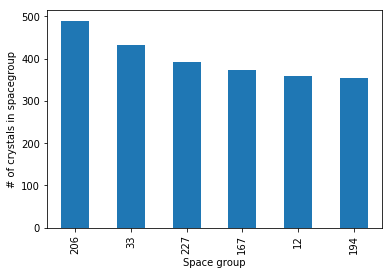

In [16]:
print(df_train.head())
#Training data spacegroup distribution
df_train['spacegroup'].value_counts(normalize=False).plot.bar()
plt.ylabel('# of crystals in spacegroup')
plt.xlabel('Space group')

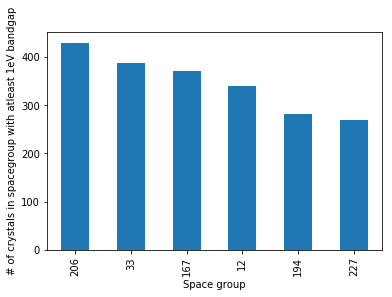

In [17]:
#Training data spacegroup distribution for structures with bandgap>1eV
df_train['spacegroup'][df_train['bandgap'] >= 1].value_counts(normalize=False).plot.bar()
plt.ylabel('# of crystals in spacegroup with atleast 1eV bandgap')
plt.xlabel('Space group')

#### Thus spacegroup 227 has fewer fraction of actually useful structures



The correlation b/w bandgap and formation energy is:-0.4542458663649036


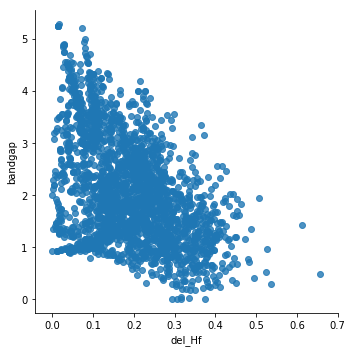

In [18]:
#Is there a coorelation b/w band gap and del_Hf?
bghf = sns.lmplot( x="del_Hf", y = "bandgap", data = df_train, fit_reg = False)
print("The correlation b/w bandgap and formation energy is:{}".format(df_train['bandgap'].corr(df_train['del_Hf'])) )

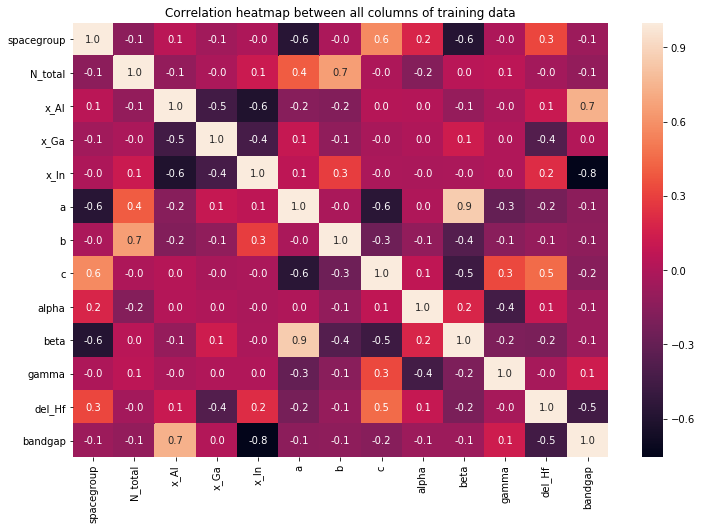

In [19]:
#Correlation in the training dataset
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(df_train.corr() ,annot=True,fmt=".1f",ax=ax) 
ax.set_title("Correlation heatmap between all columns of training data")

## Step 2: Structural feature selection to predict spacegroup

We are using unit cell lattice parameters as the features to classify the spacegroup of the structures. LDA and PCA are compared and it is shown that an LDA classification of structures using its lattice parameters is able to give a good spacegroup prediction of the crystal. We will include the coordinates of each atom to predict the spacegroup of the structure as a part of this project to extract structural features from atomic coordinates files.  

/Users/Abhinav/VirtualEnvironments/python3_env/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


confusion matrix of LDA predicitons: 
 [[358   0   0   0   0   0]
 [  0 432   0   0   0   0]
 [  0   0 374   0   0   0]
 [  0   0  13 340   0   0]
 [  0   0   0   0 490   0]
 [  0   0  14   0   0 379]]


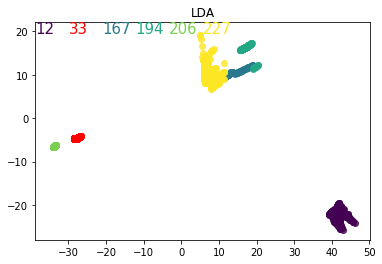

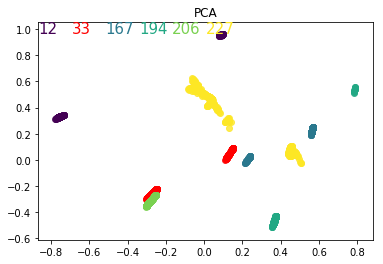

In [20]:
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

#Scaling using min max via inbuilt function
x = df_train.loc[:,['a', 'b', 'c', 'alpha', 'beta', 'gamma', 'N_total']].values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_lattice = pd.DataFrame(x_scaled)
df_lattice.columns=['a', 'b', 'c', 'alpha', 'beta', 'gamma', 'N_total']

# classification of structures using lda
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
conductors_lda = LinearDiscriminantAnalysis(n_components=2)
LDA_conductors = conductors_lda.fit_transform(x_scaled, df_train.loc[:,['spacegroup']].values)
lda_df = pd.DataFrame(LDA_conductors)
lda_df['labels'] = df_train.loc[:,['spacegroup']].values
lda_df['labels_predicted'] = conductors_lda.predict(x_scaled)
cm = confusion_matrix(lda_df['labels'], lda_df['labels_predicted'])
print('confusion matrix of LDA predicitons: \n', cm)

set_spacegroup = np.unique(df_train.loc[:,['spacegroup']])
no_spacegroups = len(set_spacegroup)
fig,ax = plt.subplots()
colors = [plt.cm.viridis((i/(no_spacegroups-1))) for i in range(no_spacegroups)]
colors[1] = 'r'
xpos=0
for label in range(no_spacegroups):
    idxs = np.array(lda_df['labels'] == set_spacegroup[label])
    c = colors[label]
    ax.scatter(lda_df.iloc[idxs,0], lda_df.iloc[idxs,1], color=c, alpha=0.8)
    ax.annotate(str(set_spacegroup[label]), xy=[xpos, 0.95], xycoords='axes fraction', color=c, size=15)
    ax.set_title('LDA')
    xpos += 0.1
    
# classification using PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_PCA = pca.fit_transform(x_scaled) 
pca_df = pd.DataFrame(X_PCA)

set_spacegroup = np.unique(df_train.loc[:,['spacegroup']])
no_spacegroups = len(set_spacegroup)
fig,ax = plt.subplots()
colors = [plt.cm.viridis((i/(no_spacegroups-1))) for i in range(no_spacegroups)]
colors[1] = 'r'
xpos=0
for label in range(no_spacegroups):
    idxs = np.array(lda_df['labels'] == set_spacegroup[label])
    c = colors[label]
    ax.scatter(pca_df.iloc[idxs,0], pca_df.iloc[idxs,1], color=c, alpha=0.8)
    ax.annotate(str(set_spacegroup[label]), xy=[xpos, 0.95], xycoords='axes fraction', color=c, size=15)
    ax.set_title('PCA')
    xpos += 0.1

## Step 3: Regression Flow

We are using the given variables (Natoms, unit cell dimensions etc) as the features in this workflow. Possible new features will be explored as a part of this project.

In [8]:
from sklearn import preprocessing
#Scaling using min max via inbuilt function
x = df_train.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_train = pd.DataFrame(x_scaled)
df_train.columns=column_names
print(df_train.head())


# Defining X and y
col = ['del_Hf','bandgap']
X = df_train.drop(['spacegroup']+col, axis=1)      #Dropping away spacegroup for now, its not a continuious variable. 
y = df_train[col]
Xtest = df_test.drop(['spacegroup'], axis=1)
print(X.shape)
print(Xtest.shape)
#X.head()
y.head()
#Xtest.head()

   spacegroup   N_total    x_Al    x_Ga   x_In         a         b         c  \
0    0.097674  1.000000  0.6250  0.3750  0.000  0.316108  0.763337  0.178158   
1    0.846512  1.000000  0.6250  0.3750  0.000  0.143854  0.441140  0.912710   
2    1.000000  0.428571  0.8125  0.1875  0.000  0.306906  0.369788  0.421404   
3    0.720930  0.285714  0.7500  0.0000  0.250  0.089896  0.280498  0.399487   
4    0.846512  1.000000  0.0000  0.6250  0.375  0.165676  0.506111  0.961130   

      alpha      beta     gamma    del_Hf   bandgap  
0  0.392655  0.340891  0.667297  0.103469  0.650511  
1  0.393520  0.340716  0.999435  0.378880  0.552573  
2  0.444922  0.386576  0.008758  0.277085  0.519050  
3  0.391908  0.341282  0.999427  0.330493  0.633579  
4  0.392298  0.340822  0.999289  0.076841  0.260916  
(2400, 10)
(600, 10)


,del_Hf,bandgap
0,0.103469,0.650511
1,0.378880,0.552573
2,0.277085,0.519050
3,0.330493,0.633579
4,0.076841,0.260916


In [9]:
#Splitting data into testing and training (from df_train for generating parity plots)
from sklearn.model_selection import train_test_split

random_number=19221
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=random_number)
print(X_train.shape)
print(X_val.shape)
#We are doing a 85-15 split b/w test and train data for validation

(2040, 10)
(360, 10)


In [23]:
#Using KNN regressor right now, but setting up a Pipeline to test for future
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('knn', KNeighborsRegressor()),
    ])  #We can add more learners here.



In [25]:
pipeline.fit(X_train, y_train)
preds = pipeline.predict(X_val)
print(dir(pipeline))
print(pipeline.get_params)

['__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_cache', '_abc_negative_cache', '_abc_negative_cache_version', '_abc_registry', '_estimator_type', '_final_estimator', '_fit', '_get_param_names', '_get_params', '_inverse_transform', '_pairwise', '_replace_estimator', '_set_params', '_transform', '_validate_names', '_validate_steps', 'classes_', 'decision_function', 'fit', 'fit_predict', 'fit_transform', 'get_params', 'inverse_transform', 'memory', 'named_steps', 'predict', 'predict_log_proba', 'predict_proba', 'score', 'set_params', 'steps', 'transform']
<bound method Pipeline.get_params of Pipeline(memory=None,
     steps=[('knn', KNei

In [12]:
#Hyperparameter tuning using inbuilt GridSeachCV
from sklearn.model_selection import GridSearchCV

hyperparameters = { 
                    'knn__n_neighbors': [2, 4, 7, 10,12]
                  }
clf = GridSearchCV(pipeline, hyperparameters, cv = 5)
 
# Fit and tune model
clf.fit(X_train, y_train)
print(clf.best_params_)   #Optimum neighbours
pred = clf.predict(X_train)  #Using train_data right now to see how good is the performance
pred_vals = pd.DataFrame(pred)
pred_vals.columns = col

pred_vals.head()

{'knn__n_neighbors': 7}


,del_Hf,bandgap
0,0.342688,0.365134
1,0.225720,0.329398
2,0.214177,0.172845
3,0.267738,0.241087
4,0.517281,0.146603


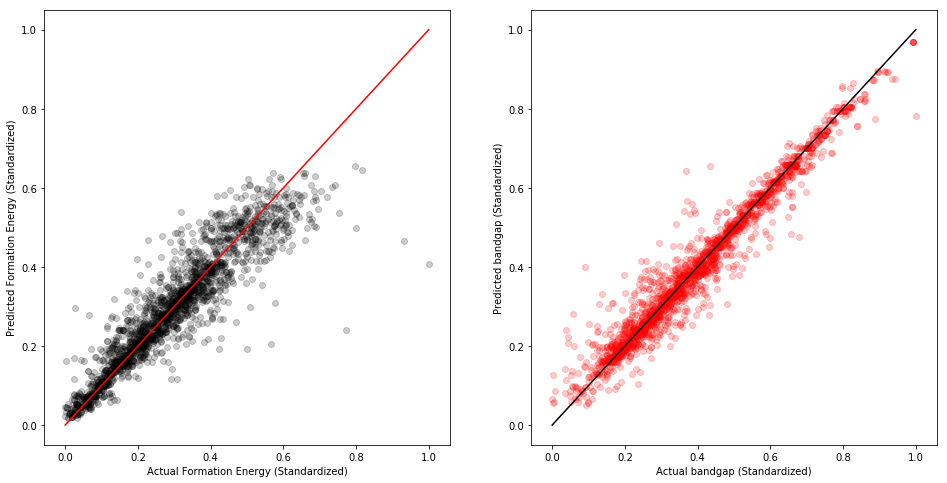

In [26]:
#Parity Plots 
fig, ax = plt.subplots(1,2,figsize=(16,8))

yp=y_train['del_Hf']
ax[0].scatter(y_train['del_Hf'], pred_vals['del_Hf'], color='k', alpha=0.2)
ax[0].plot([min(yp), max(yp)], [min(yp), max(yp)], ls='-', color='r') #<- this is called a parity plot
ax[0].set_xlabel('Actual Formation Energy (Standardized)')
ax[0].set_ylabel('Predicted Formation Energy (Standardized)')

yp=y_train['bandgap']
ax[1].scatter(y_train['bandgap'], pred_vals['bandgap'], color='r', alpha=0.2)
ax[1].plot([min(yp), max(yp)], [min(yp), max(yp)], ls='-', color='k') #<- this is called a parity plot
ax[1].set_xlabel('Actual bandgap (Standardized)')
ax[1].set_ylabel('Predicted bandgap (Standardized)')

#### Clearly, the features given are insufficient for prediction. Our efforts from here onwards will be majorly focussed on finding better features as well as the best learning algorithm.